In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

In [2]:
# Data normalization

def norm_zScore(y):
    ''' Normalize a 1D array by z-score '''
    mean, std = np.mean(y), np.std(y)
    return np.array([(j-mean)/std for j in y]), mean, std

def denorm_zScore(yNorm, mean, std):
    return np.array([j*std + mean for j in yNorm])

def norm_matrix_cols(matrix, normalizer):
    return np.array([normalizer(col)[0] for col in matrix.T]).T


In [51]:
# Morgan Fingerprints

def get_fp_counts(mols, radius=3, return_inventory=False):
    # fp_raw = [AllChem.GetMorganFingerprint(m, radius=radius) for m in mols]
    fp_raw = []
    for m in mols:
        try:
            fp_raw.append(AllChem.GetMorganFingerprint(m, radius=radius))
        except:
            raise Exception(f"failed to get fingerprint for '{Chem.MolToSmiles(m)}'")
        
    FP_INVENTORY= sorted(set(key for fp in fp_raw for key in fp.GetNonzeroElements()))

    fp_counts = np.zeros((len(mols), len(FP_INVENTORY))) # Integer matrix
    for m, fp in enumerate(fp_raw):
        for k,v in fp.GetNonzeroElements().items():
            fp_counts[m][FP_INVENTORY.index(k)] = v
            
    if return_inventory:
        return fp_counts, FP_INVENTORY
    return fp_counts
            

def get_fp_hashed(mols, nBits=2048, radius=3, counts=True):
    ''' Given a list (mols) of rdkit-encoded molecules,
        return an indicator matrix of nBit Morgan fingerprints,
        i.e. each row is the morgan representation of a molecule,
        use counts=True for count-based or False for binary vectors
    '''
    if counts: morgan = AllChem.GetHashedMorganFingerprint
    else: morgan = AllChem.GetMorganFingerprintAsBitVect
    out = []
    for m, mol in enumerate(mols):
        fp = morgan(mol, nBits=nBits, radius=3)
        vector = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, vector)
        out.append(vector)
    return np.array(out, dtype=int)


def prune(fp_matrix, lower=0.1, upper=0.9, showPlot=False, color='green'):
    ''' Reduce fingerprint dimensions by dropping bits with frequency < lower or > upper
        Return indices of bits to keep and a pruned fp_matrix
    '''
    nMols, nBits = fp_matrix.shape
    bit_matrix = np.where(fp_matrix > 0, 1, 0)
    fp_freqs = np.sum(bit_matrix, axis=0)/nMols
    fp_between = [True if lower < bit < upper else False for bit in fp_freqs]
    keep_index = np.where(fp_between)[0]
    fp_pruned = fp_matrix[:,keep_index]
    
    if showPlot:
        plt.figure(figsize=(36,12))
        plt.plot(fp_freqs, 'o-')
        plt.fill_between([0, nBits], lower, upper, color=color, alpha=0.3)
        plt.xticks(np.arange(0, nBits+1, nBits//16), size=20)
        plt.yticks(np.arange(0, 1.01, 0.1,), size=20)
        plt.grid(axis='y')
        plt.show()
        plt.close()
    
    return keep_index, fp_pruned

In [4]:
# CROW Polymer Database
crow = pd.read_csv("CROW_PolymerDatabase.csv", skiprows=2, usecols = [2,6]).dropna()
crow_smiles = np.array(crow['SMILES'])
crow_mols = np.array([Chem.MolFromSmiles(sm) for sm in crow_smiles])

# Morgan Fingerprints
crow_fp_counts, crow_fp_inventory = get_fp_counts(crow_mols, 3, True)
crow_fp_bits = np.where(crow_fp_counts > 0, 1, 0)
crow_fp_counts_2048 = get_fp_hashed(crow_mols, 2048, 3)
crow_fp_bits_2048 = np.where(crow_fp_counts_2048 > 0, 1, 0)

# Glass Transition Temp (Labels)
crow_Tg_Kelvin = np.array(crow['Glass Trans'], dtype=int)
crow_Tg_Celsius = crow_Tg_Kelvin - 273 # Celsius
crow_Tg_zScore = norm_zScore(crow['Glass Trans'])[0]

print('Database Imported:\tCROW PolymerDatabase (Glass Transition Temperature)')
crow

Database Imported:	CROW PolymerDatabase (Glass Transition Temperature)


,SMILES,Glass Trans
2,[*]CC[*],193.0
3,[*]CC([*])C,264.0
4,[*]CC([*])CC,245.0
5,[*]CC([*])CCC,238.0
6,[*]CC([*])CCCC,223.0
...,...,...
281,[*]CC([*])SCCCC,253.0
282,[*]CC([*])Sc1ccccc1,386.0
285,[*]O[Si]([*])(C)C,149.0
286,[*]O[Si]([*])(CC)CC,137.0


In [5]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    pd.DataFrame(crow_fp_counts, columns=crow_fp_inventory).to_csv('crow_fp_counts.csv', index=False)

In [6]:
# chemprop's "Extended String Represenation"

if False: #__name__ == "__main__" and '__file__' not in globals():
    
    fileName = 'crow_TgZ_chemprop.csv'
    with open(fileName, 'w') as f:
        f.write('Extended_String_Representation,Tg_zScore\n')
        for sm, tg in zip(crow_smiles, crow_Tg_zScore):
            chemprop_str = sm.replace('[*]','[*:1]', 1).replace('[*]','[*:2]', 1) + '|1|<1-2:1:1'
            f.write(f'{chemprop_str},{tg}\n')
    print(f'downloaded: {fileName}')

Number of datapoints not included in any test set: 23


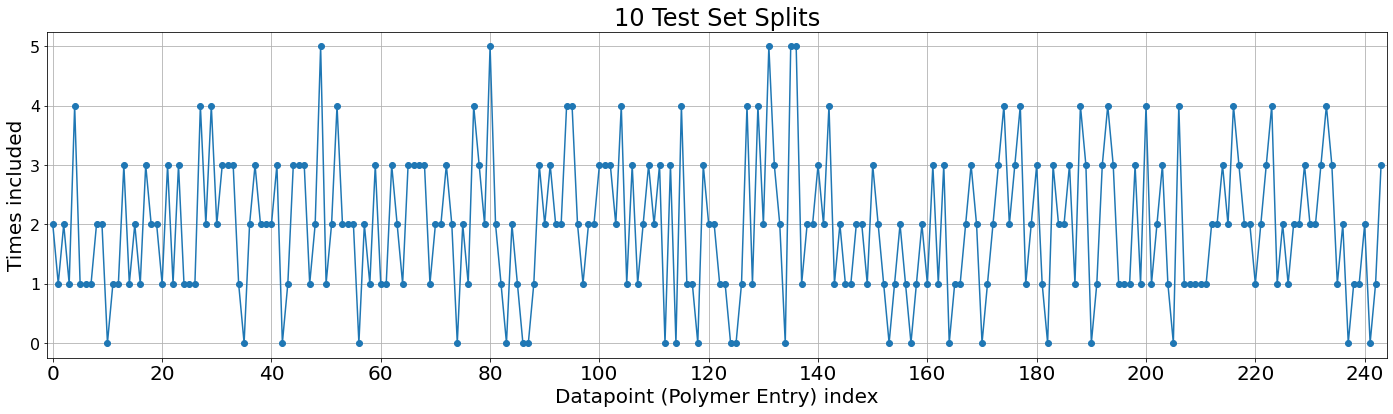

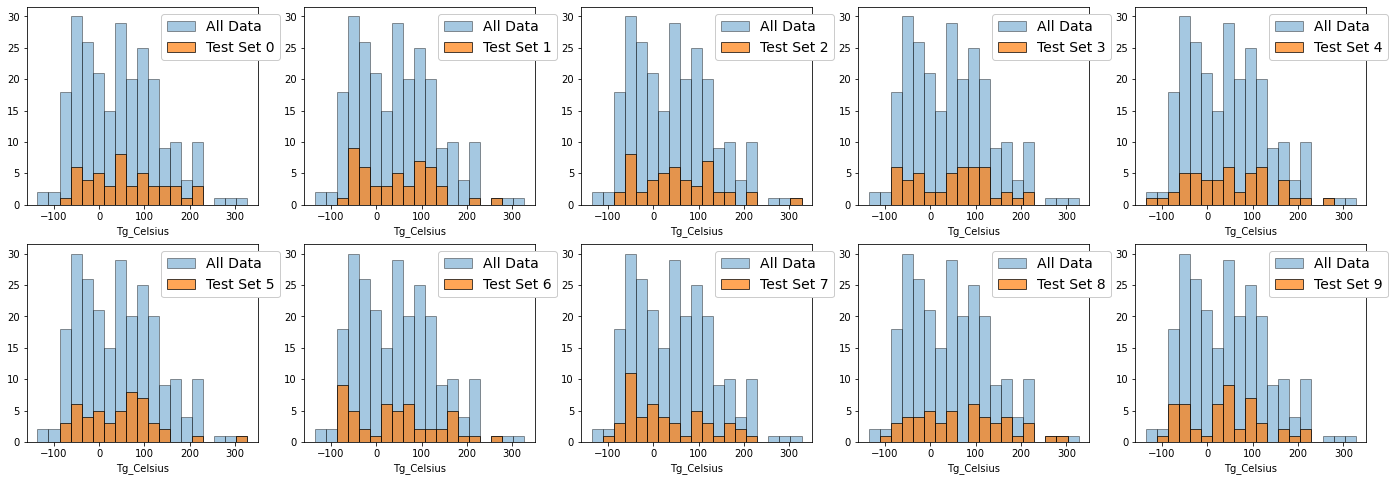

In [7]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    NEW_SPLIT = False
    
    if NEW_SPLIT:
        TEST_SIZE = 0.2
        max_inclusions, unincluded = 100, 100
        while max_inclusions > 5 or unincluded > len(crow)/10:
            ''' Let no data entry be part of more than 5 of the 10 test set splits
                and 90% of data entries be part of at least one test set
            '''
            TEN_TEST_INDICES = [sorted(np.random.choice(list(range(len(crow))), size=int(TEST_SIZE*len(crow)),
                                   replace=False)) for i in range(10)]
            inclusions = [0] * len(crow)
            for test_idx in TEN_TEST_INDICES:
                for i in test_idx:
                    inclusions[i] += 1
            max_inclusions = max(inclusions)
            unincluded = inclusions.count(0)
            
        with open('TEN_TEST_INDICES.txt', 'w') as f:
            f.write(f'{TEN_TEST_INDICES}')
            
    else:
        with open('TEN_TEST_INDICES_v6.txt') as f:
            TEN_TEST_INDICES = eval(f.read())
        inclusions = [0] * len(crow)
        for test_idx in TEN_TEST_INDICES:
            for i in test_idx:
                inclusions[i] += 1
        unincluded = inclusions.count(0)
        
    print('Number of datapoints not included in any test set:', unincluded)
    plt.figure(figsize=(24,6))
    plt.plot(inclusions, 'o-')
    plt.title('10 Test Set Splits', size=24)
    plt.xlabel('Datapoint (Polymer Entry) index', size=20)
    plt.ylabel('Times included', size=20)
    plt.xlim(-1, len(crow))
    plt.xticks(np.arange(0,250,20), size=20)
    plt.yticks(size=16)
    plt.grid()
    
    bins = np.linspace(min(crow_Tg_Celsius), max(crow_Tg_Celsius), 20)
    plt.figure(figsize=(24,8))
    for i,ti in enumerate(TEN_TEST_INDICES):
        plt.subplot(2,5,i+1)
        plt.xlabel('Tg_Celsius')
        plt.hist(crow_Tg_Celsius, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
        test_idx = np.array(ti)
        plt.hist(crow_Tg_Celsius[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
        #plt.title(f'Test Set #{i}', size=16)
        plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0.55,1), loc='upper left')
    if NEW_SPLIT: plt.savefig(f'TEN_TEST_INDICES.png', facecolor='w', bbox_inches='tight')


[17, 29, 31, 44, 49, 51, 68, 75, 77, 78, 81, 91]


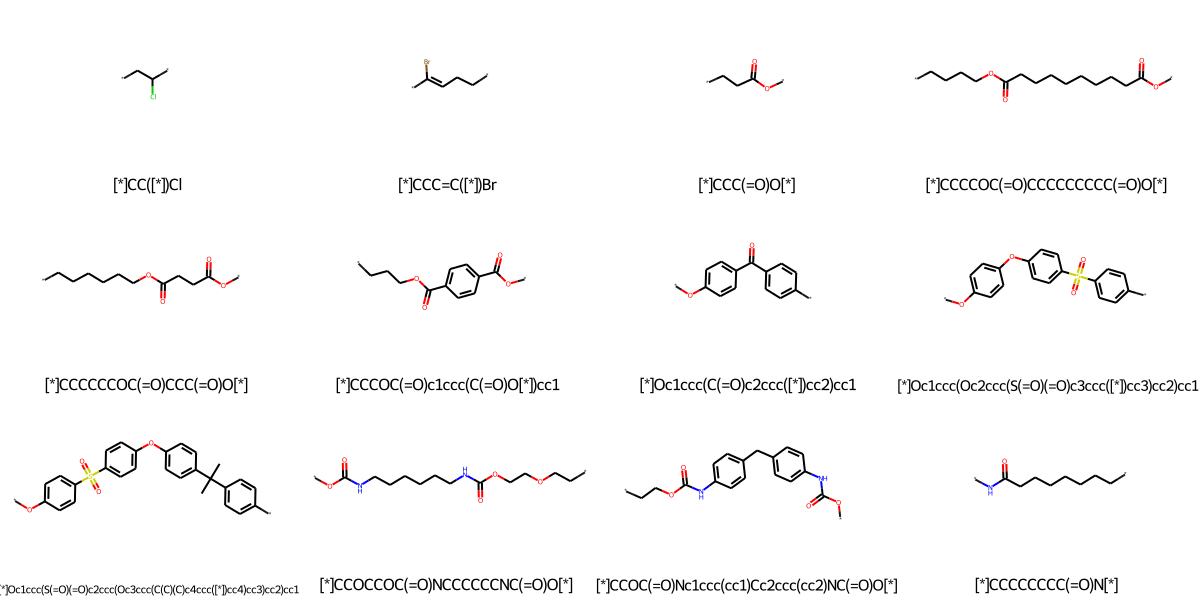

done


In [8]:
if __name__ == "__main__" and '__file__' not in globals():
    with open('TEN_TEST_INDICES_v6.txt') as f:
        some_mol_indices = eval(f.read())[0][:12]
    print(some_mol_indices)
    some_mols = crow_mols[some_mol_indices]
    some_smiles = crow_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, subImgSize=(300,200), legends=list(some_smiles))
    display(some_drawings)
    print('done')

In [9]:
if __name__ == "__main__" and '__file__' not in globals():
    print('crow_Tg Mean:\t', np.mean(crow_Tg_Kelvin), '[K]')
    print('crow_Tg St.Dev:\t', np.std(crow_Tg_Kelvin), '[K]')

crow_Tg Mean:	 316.84016393442624 [K]
crow_Tg St.Dev:	 86.12897225828372 [K]


In [10]:
# Freesolv Database
freesolv = pd.read_csv('freesolv.txt', sep='; ', skiprows=2, engine='python')
freesolv_smiles = np.array(freesolv['SMILES'])
freesolv_mols = np.array([Chem.MolFromSmiles(sm) for sm in freesolv_smiles])
freesolv_fp_counts, freesolv_fp_inventory = get_fp_counts(freesolv_mols, 3, True)
freesolv_fp_bits = np.where(freesolv_fp_counts > 0, 1, 0)
freesolv_fp_counts_2048 = get_fp_hashed(freesolv_mols, 2048, 3)
freesolv_fp_bits_2048 = np.where(freesolv_fp_counts_2048 > 0, 1, 0)

freesolv_DGhy_exp = np.array(freesolv['experimental value (kcal/mol)'])
freesolv_DGhy_exp_err = np.array(freesolv['experimental uncertainty (kcal/mol)'])
freesolv_DGhy_calc = np.array(freesolv['Mobley group calculated value (GAFF) (kcal/mol)'])
freesolv_DGhy_calc_err = np.array(freesolv['calculated uncertainty (kcal/mol)'])
freesolv_DGhy_exp_zScore = norm_zScore(freesolv_DGhy_exp)[0]

print('Database Imported:\tFreesolv (Hydration Free Energy)')
freesolv

Database Imported:	Freesolv (Hydration Free Energy)


,# compound id (and file prefix),SMILES,iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem),experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
0,mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
1,mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
2,mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1007/s10822-011-9528-8,Experimental uncertainty not presently availab...
3,mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
4,mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provide...",10.1021/ct800409d,Experimental uncertainty not presently availab...
...,...,...,...,...,...,...,...,...,...,...
638,mobley_9913368,C(=C/Cl)\Cl,"(E)-1,2-dichloroethylene",-0.78,0.6,1.02,0.02,10.1021/ct050097l,10.1021/ct800409d,"Renamed mobley_9913368 from (E)-1,2-dichloroet..."
639,mobley_9942801,CCc1ccc(cc1)C,1-ethyl-4-methyl-benzene,-0.95,0.6,-0.57,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
640,mobley_994483,CCBr,bromoethane,-0.74,0.6,0.49,0.02,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...
641,mobley_9974966,CC(C)SC(C)C,2-isopropylsulfanylpropane,-1.21,0.6,0.14,0.03,10.1021/ct050097l,10.1021/ct800409d,Experimental uncertainty not presently availab...


Number of datapoints not included in any test set: 63


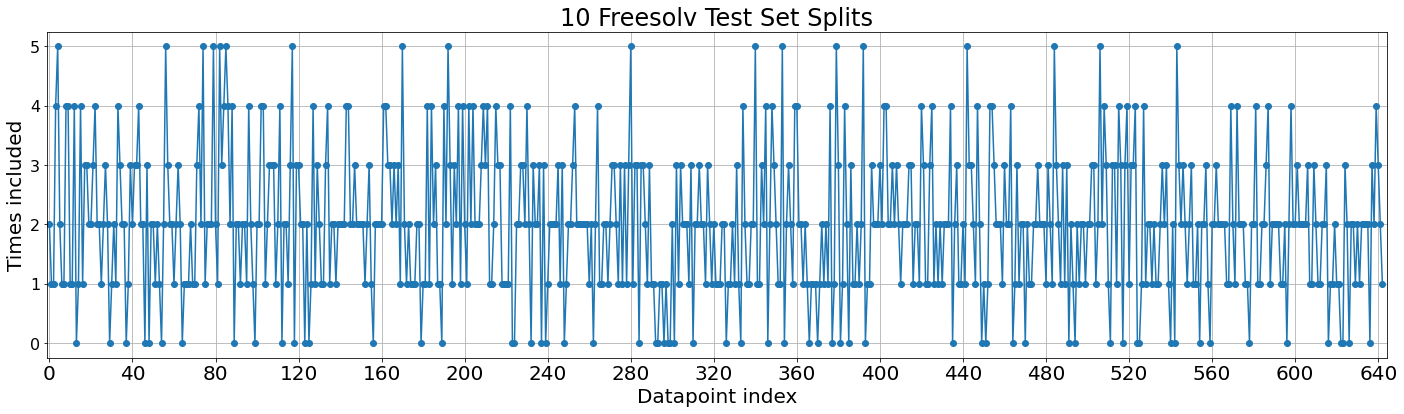

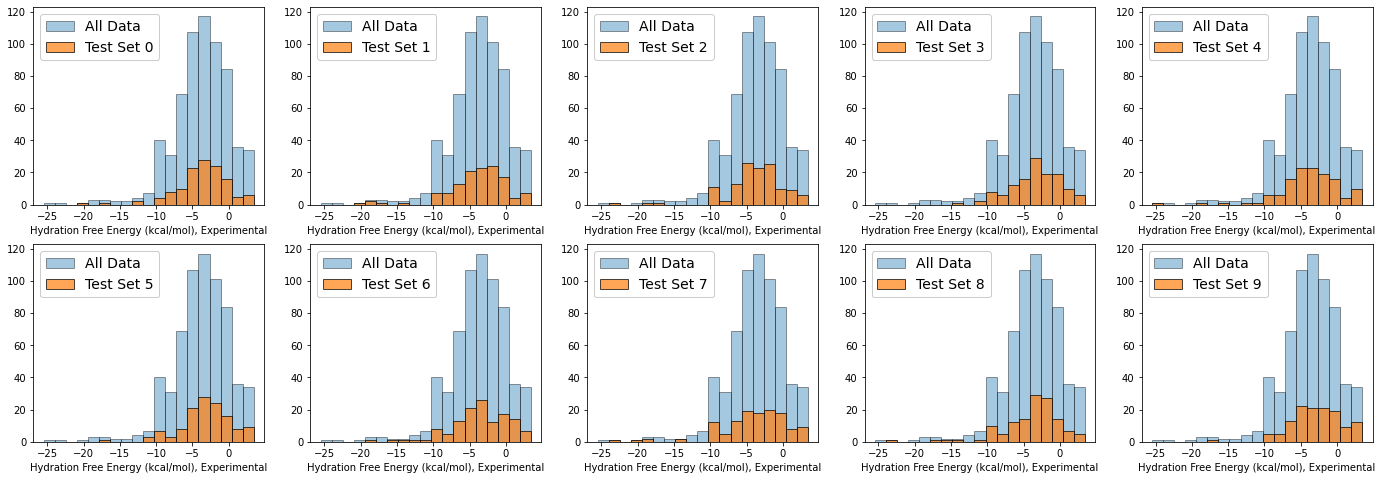

In [11]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    NEW_FREESOLV_SPLIT = False
    
    if NEW_FREESOLV_SPLIT:
        
        TEST_SIZE = 0.2
        
        max_inclusions, unincluded = 100, 100
        while max_inclusions > 5 or unincluded > len(freesolv)/10:
            ''' Let no data entry be part of more than 5 of the 10 test set splits
                and 90% of data entries be part of at least one test set
            '''
            TEN_FREESOLV_TEST_INDICES = [sorted(np.random.choice(list(range(len(freesolv))), size=int(TEST_SIZE*len(freesolv)),
                                   replace=False)) for i in range(10)]
            inclusions = [0] * len(freesolv)
            for test_idx in TEN_FREESOLV_TEST_INDICES:
                for i in test_idx:
                    inclusions[i] += 1
            max_inclusions = max(inclusions)
            unincluded = inclusions.count(0)
            # print(max_inclusions, unincluded)
            
        with open('TEN_FREESOLV_TEST_INDICES.txt', 'w') as f:
            f.write(f'{TEN_FREESOLV_TEST_INDICES}')
            
    else:
        with open('TEN_FREESOLV_TEST_INDICES_v1.txt') as f:
            TEN_FREESOLV_TEST_INDICES = eval(f.read())
        inclusions = [0] * len(freesolv)
        for test_idx in TEN_FREESOLV_TEST_INDICES:
            for i in test_idx:
                inclusions[i] += 1
        unincluded = inclusions.count(0)
        
    print('Number of datapoints not included in any test set:', unincluded)
    plt.figure(figsize=(24,6))
    plt.plot(inclusions, 'o-')
    plt.title('10 Freesolv Test Set Splits', size=24)
    plt.xlabel('Datapoint index', size=20)
    plt.ylabel('Times included', size=20)
    plt.xlim(-1, len(freesolv)+1)
    plt.xticks(np.arange(0,661,40), size=20)
    plt.yticks(size=16)
    plt.grid()
    
    bins = np.linspace(min(freesolv_DGhy_exp), max(freesolv_DGhy_exp), 20)
    plt.figure(figsize=(24,8))
    for i,ti in enumerate(TEN_FREESOLV_TEST_INDICES):
        plt.subplot(2,5,i+1)
        plt.xlabel('Hydration Free Energy (kcal/mol), Experimental')
        plt.hist(freesolv_DGhy_exp, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
        test_idx = np.array(ti)
        plt.hist(freesolv_DGhy_exp[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
        #plt.title(f'Test Set #{i}', size=16)
        plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')
    if NEW_FREESOLV_SPLIT: plt.savefig(f'TEN_FREESOLV_TEST_INDICES.png', facecolor='w', bbox_inches='tight')


[3, 4, 16, 17, 18, 23, 31, 32, 34, 36, 38, 42]


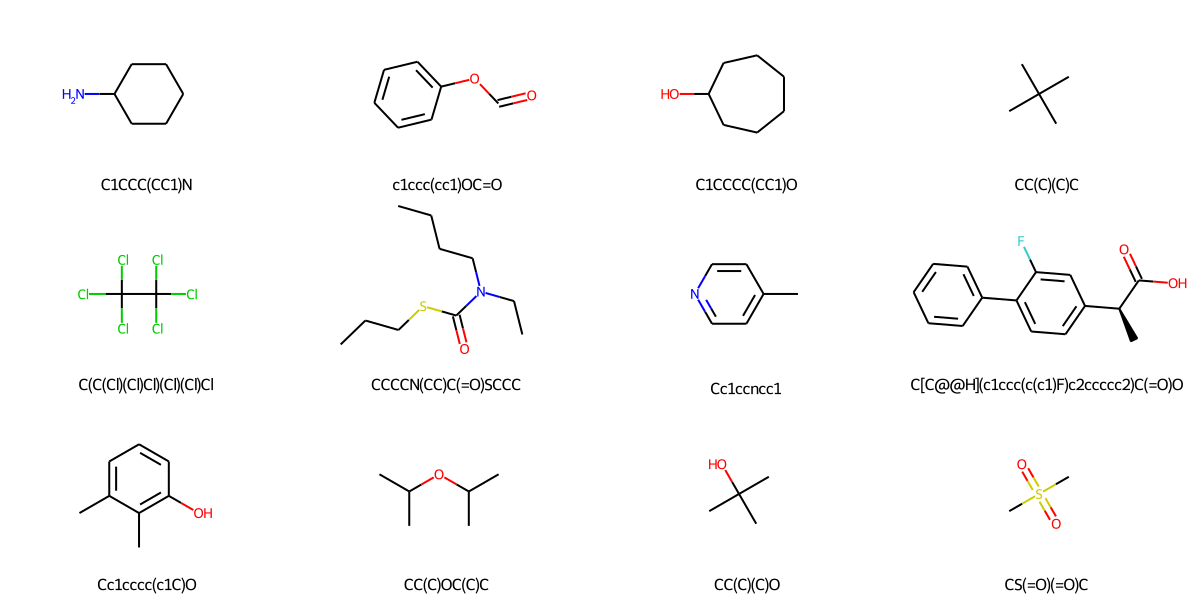

done


In [12]:
if __name__ == "__main__" and '__file__' not in globals():
    with open('TEN_FREESOLV_TEST_INDICES_v1.txt') as f:
        some_mol_indices = eval(f.read())[0][:12]
    print(some_mol_indices)
    some_mols = freesolv_mols[some_mol_indices]
    some_smiles = freesolv_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, subImgSize=(300,200), legends=list(some_smiles))
    display(some_drawings)
    print('done')

In [13]:
if __name__ == "__main__" and '__file__' not in globals():
    print('Unique fingerprints in Freesolv database:', len(freesolv_fp_inventory))
    print('freesolv_DGhy_exp Mean:\t', np.mean(freesolv_DGhy_exp), '[kcal/mol]')
    print('freesolv_DGhy_exp St.Dev:\t', np.std(freesolv_DGhy_exp), '[kcal/mol]')

Unique fingerprints in Freesolv database: 3181
freesolv_DGhy_exp Mean:	 -3.806951788491446 [kcal/mol]
freesolv_DGhy_exp St.Dev:	 3.843131787620932 [kcal/mol]


In [14]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    
    fileName = 'freesolv_DGhy_exp.csv'
    with open(fileName, 'w') as f:
        f.write('SMILES,Experimental Hydration Free Energy [kcal/mol]\n')
        for sm, dg in zip(freesolv_smiles, freesolv_DGhy_exp):
            f.write(f'{sm},{dg}\n')
    print(f'downloaded: {fileName}')

In [15]:
# Bicerano_1996 with MD calculations by Azfal_2021
bicerano = pd.read_csv('Azfal_Bicerano.csv', skiprows=1)
bicerano_smiles = np.array(bicerano['SMILES'])
bicerano_mols = np.array([Chem.MolFromSmiles(sm) for sm in bicerano_smiles])
bicerano_fp_counts, bicerano_fp_inventory = get_fp_counts(bicerano_mols, 3, True)
bicerano_fp_bits = np.where(bicerano_fp_counts > 0, 1, 0)
bicerano_fp_counts_2048 = get_fp_hashed(bicerano_mols, 2048, counts=True)
bicerano_fp_bits_2048 = np.where(bicerano_fp_counts_2048 > 0, 1, 0)

bicerano_Tg_Kelvin = np.array(bicerano['Experiment Tg (K)'])
bicerano_Tg_Celsius = bicerano_Tg_Kelvin - 273
azfal_Tg_Kelvin = np.array(bicerano['Calculated Tg (K)'])
azfal_Tg_Celsius = azfal_Tg_Kelvin - 273
azfal_Tg_err = np.array(bicerano['Calculated Tg St.Dev. (K)'])

print('Database Imported:\tBicerano_1996 (Glass Transition Temperature) with MD simulations by Azfal_2021')
bicerano

Database Imported:	Bicerano_1996 (Glass Transition Temperature) with MD simulations by Azfal_2021


,SMILES,Experiment Tg (K),Calculated Tg (K),Calculated Tg St.Dev. (K)
0,[*]O[Si](CC)(CC)[*],130,138.0,3.8
1,[*][Si](C)(C)O[*],152,193.3,51.1
2,[*]C/C=C\C[*],171,211.7,3.1
3,[*][Si](C)(C)C[*],173,258.7,4.7
4,[*][Si](C)(C1=CC=CC=C1)O[*],187,286.9,5.8
...,...,...,...,...
309,[*]C3=C(N=C2C=C1N=C(C(=NC1=CC2=N3)C4=CC=C(C=C4...,668,951.1,48.6
310,[*]C3=C(N=C2C=C1N=C(C(=NC1=CC2=N3)C4=CC(=CC=C4...,668,693.4,37.1
311,[*]C1=CC=C(C=C1)N5C(=O)C4=CC2=C(C(N(C2=O)C3=CC...,672,817.2,39.0
312,[*]C1=CC=C(C=C1)C1(OC(=O)C2=CC=CC=C12)C1=CC=C(...,673,842.1,38.1


In [16]:
# IBM Permeability Database
diffusers = ['CH4', 'CO2', 'H2', 'He', 'N2', 'O2']
perm, perm_smiles, perm_mols, perm_X, perm_y = {}, {}, {}, {}, {}
for d in diffusers:
    df = pd.read_csv(f'logperm_{d}.txt', sep=',')
    perm[d] = df
    perm_smiles[d] = np.array(df['SMILES'])
    perm_mols[d] = np.array([Chem.MolFromSmiles(sm) for sm in perm_smiles[d]])
    perm_X[d] = {'fp_counts':None, 'fp_bits':None, 'fp_counts_2048':None, 'fp_bits_2048':None}
    perm_X[d]['fp_counts'], inventory = get_fp_counts(perm_mols[d], 3, True)
    if __name__ == "__main__" and '__file__' not in globals():
        print(d, 'fingerprint inventory:', len(inventory))
    perm_X[d]['fp_bits'] = np.where(perm_X[d]['fp_counts'] > 0, 1, 0)
    perm_X[d]['fp_counts_2048'] = get_fp_hashed(perm_mols[d], 2048, 3)
    perm_X[d]['fp_bits_2048'] = np.where(perm_X[d]['fp_counts_2048'] > 0, 1, 0)
    
    perm_y[d] = df[f'{d}_log_permeability']
    

if __name__ == "__main__" and '__file__' not in globals():
    print()
print('Database Imported:\tIBM Log-Permeability Database', tuple([permol for permol in diffusers]))
perm['CH4']

CH4 fingerprint inventory: 1659
CO2 fingerprint inventory: 2450
H2 fingerprint inventory: 1726
He fingerprint inventory: 1716
N2 fingerprint inventory: 2139
O2 fingerprint inventory: 2970

Database Imported:	IBM Log-Permeability Database ('CH4', 'CO2', 'H2', 'He', 'N2', 'O2')


,SMILES,CH4_log_permeability
0,*C*,0.332438
1,*C*,-0.409522
2,*C*,0.461609
3,*C*,1.114822
4,*C*,0.661671
...,...,...
247,*Oc1c(C)cc(-c2cc(C)c(Oc3ccc(C(=O)c4ccc(*)c(S(=...,-0.055517
248,*Oc1c(C)cc(-c2cc(C)c(Oc3ccc(C(=O)c4ccc(*)c(S(=...,0.120574
249,*Oc1c(C)cc(-c2cc(C)c(Oc3ccc(C(=O)c4ccc(*)c(S(=...,0.029384
250,*Oc1c(C)cc(-c2cc(C)c(Oc3ccc(C(=O)c4ccc(*)c(S(=...,-0.080922


In [17]:
# chemprop's "Extended String Represenation"
# for polymers with multiple connection points (*), assume equal probability for each connection

if False: #__name__ == "__main__" and '__file__' not in globals():  
    for d in diffusers:
        fileName = f'perm_{d}_chemprop.csv'
        with open(fileName, 'w') as f:
            f.write(f'Extended_String_Representation,{d}_Permeability\n')
            for sm, v in zip(perm_smiles[d], perm_y[d]):
                connects = sm.count('*')
                connects_prob = round(1/connects,3)
                chemprop_str = sm.replace('*','[*]') + '|1|'
                for i in range(connects):
                    chemprop_str = chemprop_str.replace('[*]',f'[*:{i+1}]',1)
                    for j in range(i, connects):
                        chemprop_str += f'<{i+1}-{j+1}:{connects_prob}:{connects_prob}'
                f.write(f'{chemprop_str},{v}\n')
        print(f'downloaded: {fileName}')

In [18]:
if __name__ == "__main__" and '__file__' not in globals():
    for d in diffusers:
        print(d, 'Log-permeability mean:\t', round(np.mean(perm_y[d]),5), '\tstd:\t', np.std(perm_y[d]))

CH4 Log-permeability mean:	 1.65158 	std:	 1.6436249265078875
CO2 Log-permeability mean:	 1.54241 	std:	 1.812625449535809
H2 Log-permeability mean:	 2.27066 	std:	 1.3820296767900322
He Log-permeability mean:	 1.85319 	std:	 1.2963274848813315
N2 Log-permeability mean:	 0.7541 	std:	 1.903301612400055
O2 Log-permeability mean:	 0.83246 	std:	 1.7893061062603492


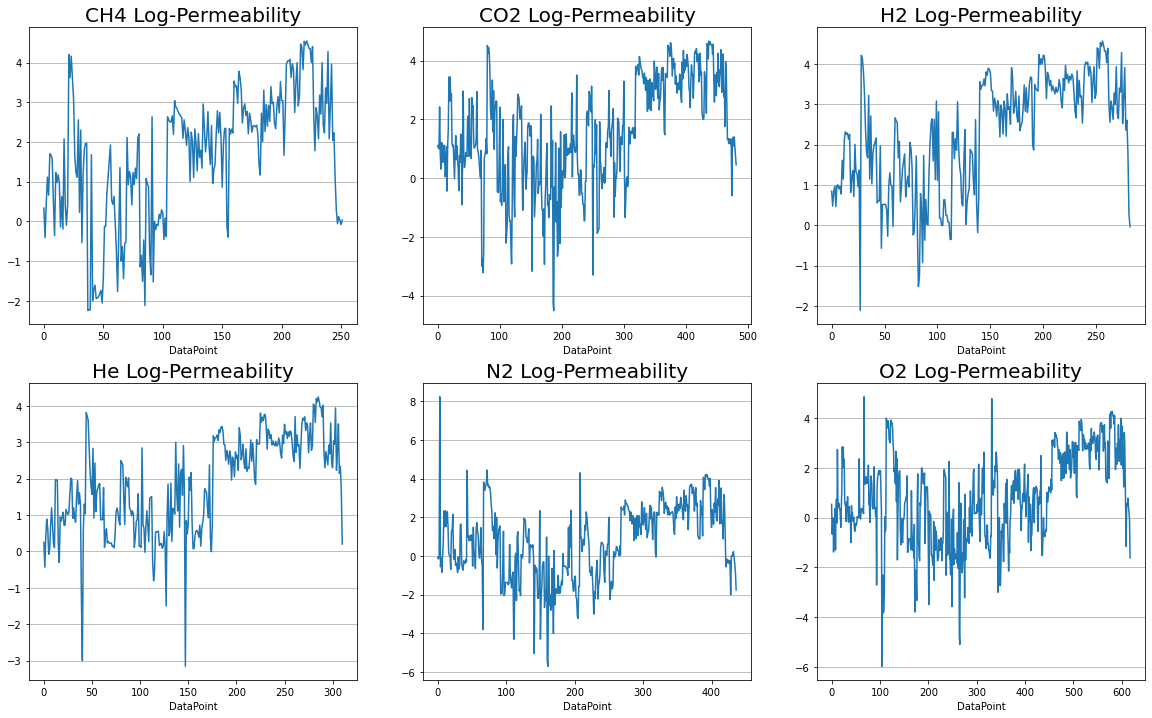

In [19]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.figure(figsize=(20,12))
    for i,d in enumerate(diffusers):
        plt.subplot(2,3,i+1)
        plt.title(f'{d} Log-Permeability', size=20)
        plt.xlabel('DataPoint')
        plt.plot(perm_y[d])
        # plt.yscale('log')
        plt.grid(axis='y')

In [20]:
with open('perm_test_idx.txt') as f:
    perm_test_idx = [int(e) for e in f.read().split('\n')[:-1]]

with open('perm_train_idx.txt') as f:
    perm_train_idx = [int(e) for e in f.read().split('\n')[:-1]]
    
len(perm_test_idx + perm_train_idx)

353

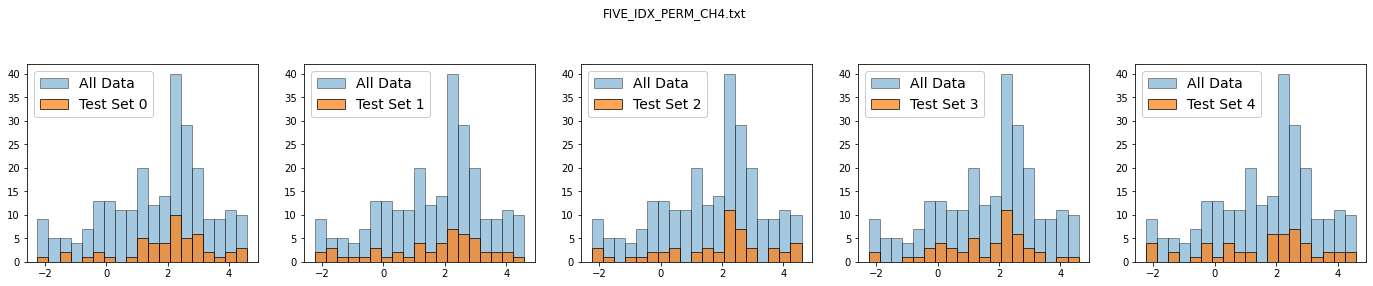

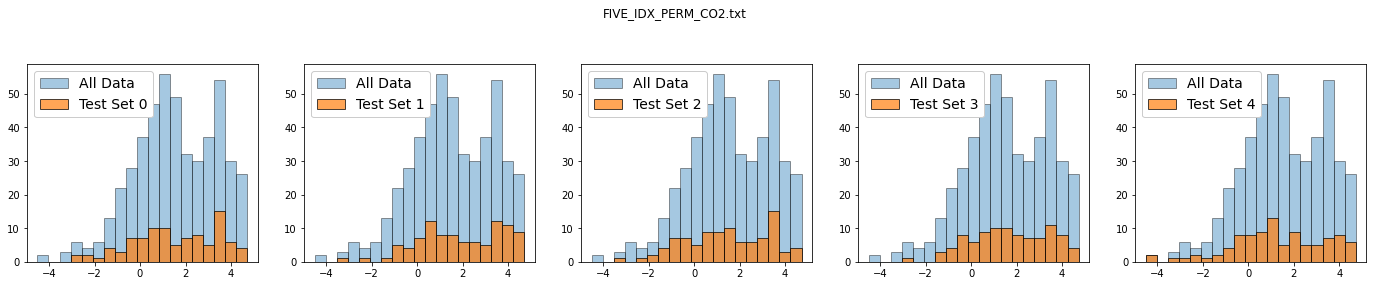

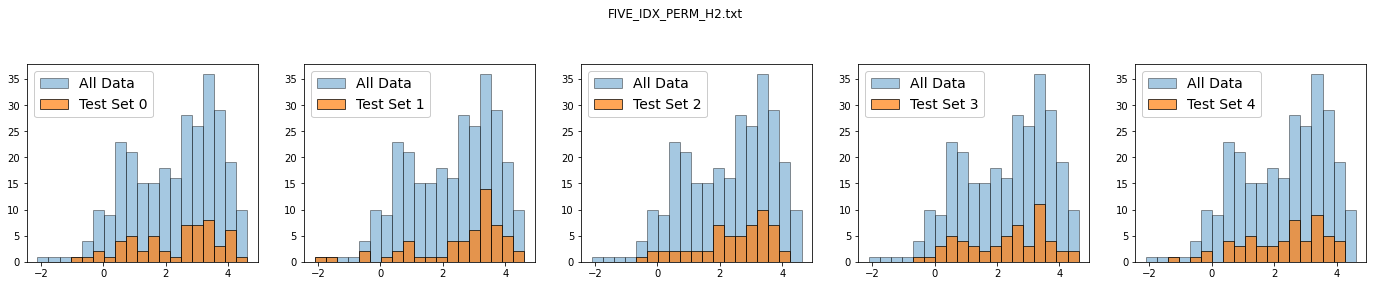

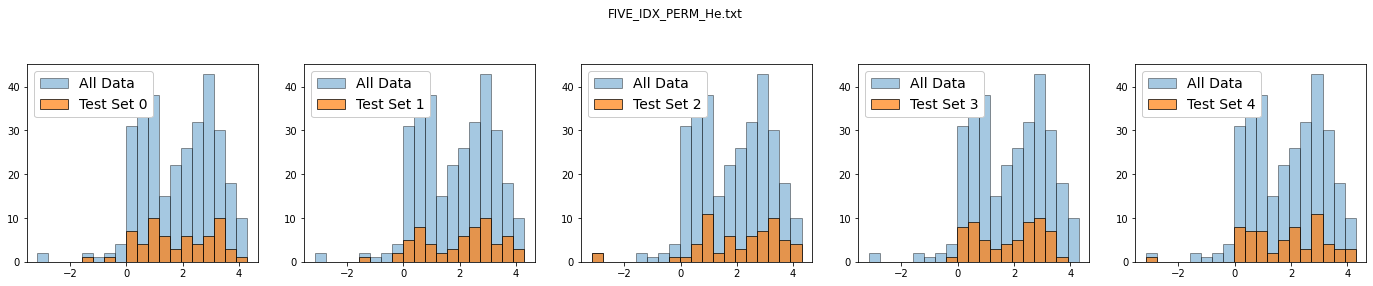

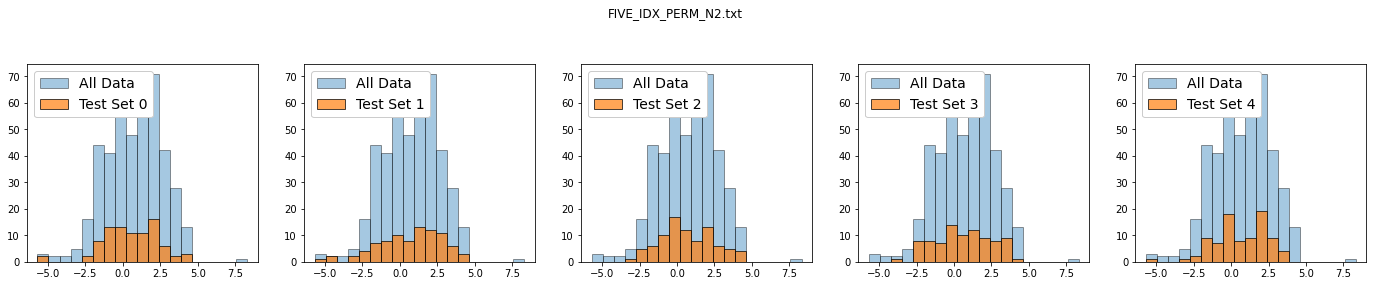

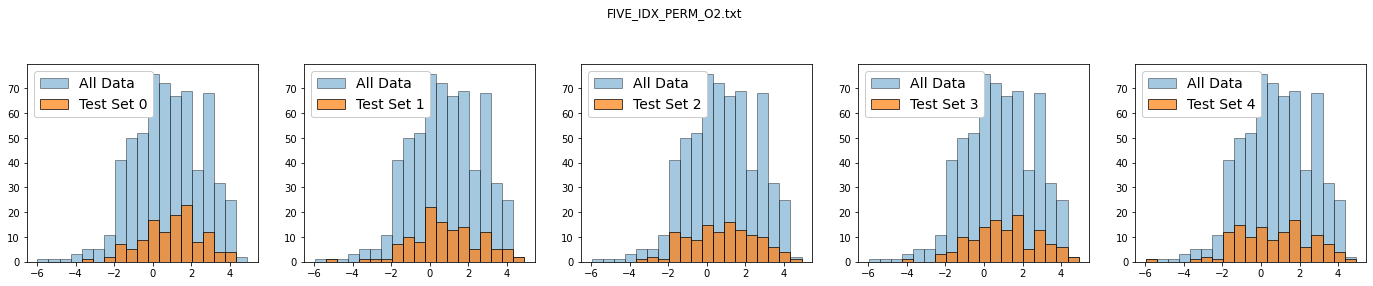

In [21]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    def get_n_splits(y, saveLoc, n=5, test_size=0.2):
        out = [sorted(np.random.choice(list(range(len(y))), size=int(test_size*len(y)), replace=False)) for i in range(n)]
        with open(saveLoc, 'w') as f:
            f.write(f'{out}')
    
    def split_hist(y, fileName):
        with open(fileName) as f:
            splits = eval(f.read())
    
        bins = np.linspace(min(y), max(y)*1.01, 20)
        plt.figure(figsize=(24,8))
        plt.suptitle(fileName)
        for i,ti in enumerate(splits):
            plt.subplot(2,5,i+1)
            plt.hist(y, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
            test_idx = np.array(ti)
            plt.hist(y[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
            plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')
    
    for d in diffusers:
        if False: get_n_splits(perm_y[d], f'FIVE_IDX_PERM_{d}.txt')
        split_hist(perm_y[d], f'FIVE_IDX_PERM_{d}.txt')


In [22]:
# Lipophilicity dataset
lipo = pd.read_csv('logd74.tsv', sep='\t')
lipo_smiles = np.array(lipo['SMILES'])
lipo_mols = np.array([Chem.MolFromSmiles(sm) for sm in lipo_smiles])

# Morgan Fingerprints
lipo_fp_counts, lipo_fp_inventory = get_fp_counts(lipo_mols, 3, True)

# LogD7.4 (labels)
lipo_y = np.array(lipo['logD7.4'], dtype=float)
lipo_y_zScore = norm_zScore(lipo_y)[0]

print('Database Imported:\tLipophilicity Database (Log D7.4)')
lipo

Database Imported:	Lipophilicity Database (Log D7.4)


,ID,SMILES,logD7.4
0,A-logD7.4-100,Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1,-0.960
1,A-logD7.4-101,S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1,-0.920
2,A-logD7.4-104,OC=1C(=O)C=CN(CCCO)C=1C,-0.900
3,A-logD7.4-105,Fc1cc2c(N(C=C(C(O)=O)C2=O)c2ccccc2C)cc1N1CCNCC1,-0.830
4,A-logD7.4-106,OC=1C(=O)C=CN(CCC(=O)NCC)C=1C,-0.820
...,...,...,...
1125,O-88,O(CC(O)CNC(C)C)c1ccccc1CC=C,1.000
1126,O-9,O1CCC[C@H]1C(=O)N1CCN(CC1)c1nc(N)c2cc(OC)c(OC)...,1.140
1127,O-94,O1c2c(C=CC1=O)cccc2,1.415
1128,O-97,Clc1cccc(Cl)c1C=NN=C(N)N,1.670


In [23]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    fileName = 'lipophilicity.txt'
    with open(fileName, 'w') as f:
        f.write('SMILES,Lipophilicity [LogD7.4]\n')
        for sm, dg in zip(lipo_smiles, lipo_y):
            f.write(f'{sm},{dg}\n')
    print(f'downloaded: {fileName}')

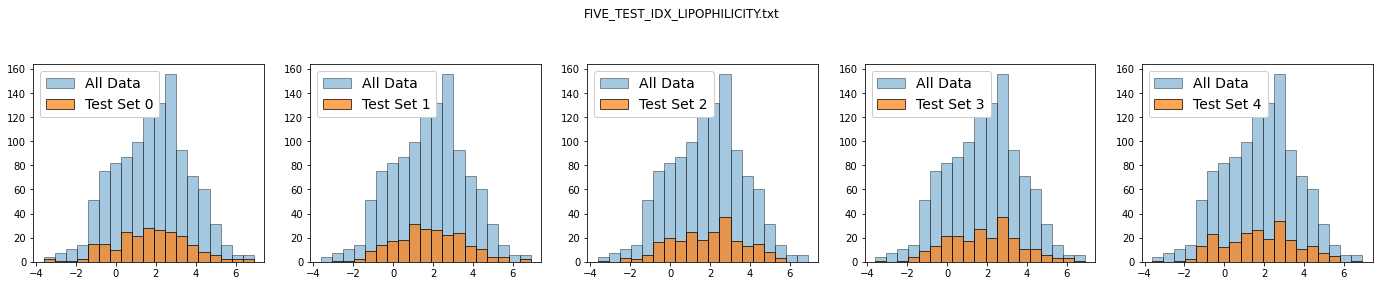

In [24]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():
    
    def get_n_splits(y, saveLoc, n=5, test_size=0.2):
        out = [sorted(np.random.choice(list(range(len(y))), size=int(test_size*len(y)), replace=False)) for i in range(n)]
        with open(saveLoc, 'w') as f:
            f.write(f'{out}')
    
    def split_hist(y, fileName):
        with open(fileName) as f:
            splits = eval(f.read())
    
        bins = np.linspace(min(y), max(y)*1.01, 20)
        plt.figure(figsize=(24,8))
        plt.suptitle(fileName)
        for i,ti in enumerate(splits):
            plt.subplot(2,5,i+1)
            plt.hist(y, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
            test_idx = np.array(ti)
            plt.hist(y[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
            plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')

    if False:
        get_n_splits(lipo_y, f'FIVE_TEST_IDX_LIPOPHILICITY.txt')
    split_hist(lipo_y, f'FIVE_TEST_IDX_LIPOPHILICITY.txt')


Lipophilicity mean: 1.8310212389380527
Lipophilicity st. dev.: 1.8196684448290106


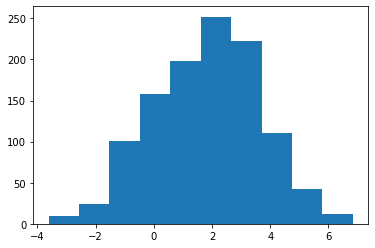

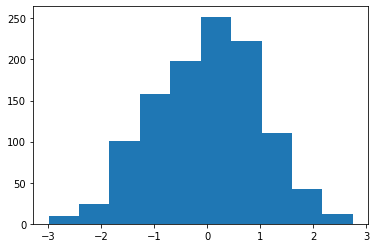

In [25]:
if __name__ == "__main__" and '__file__' not in globals():
    print('Lipophilicity mean:', np.mean(lipo_y))
    print('Lipophilicity st. dev.:', np.std(lipo_y))
    
    plt.hist(lipo_y)
    plt.figure()
    plt.hist(lipo_y_zScore)

In [26]:
# Bayesian Log-Permeability dataset

bayes_logperm = pd.read_csv('permeability_Bayesian.txt')
bayes_logperm_smiles = np.array(bayes_logperm['SMILES'])
bayes_logperm_mols = np.array([Chem.MolFromSmiles(sm) for sm in bayes_logperm_smiles])
bayes_logperm_fp_counts, bayes_logperm_fp_inventory = get_fp_counts(bayes_logperm_mols, 3, True)

bayes_logperm_y = []
bayes_logperm_y_zScore = []
for j in range(6): # 6 molecules, actually not known which corresponds to which, sigh...
    bayes_logperm_y.append(np.array(bayes_logperm[f'y{j}']))
    bayes_logperm_y_zScore.append(norm_zScore(bayes_logperm[f'y{j}'])[0])
bayes_logperm_y = np.array(bayes_logperm_y).T
bayes_logperm_y_zScore = np.array(bayes_logperm_y_zScore).T
bayes_logperm_std = np.array([[np.std(bayes_logperm[f'y{j}'])]*71 for j in range(6)]).T

print('Database Imported:\tBaysian Log-Permeability Database')
bayes_logperm

Database Imported:	Baysian Log-Permeability Database


,SMILES,y0,y1,y2,y3,y4,y5
0,*C(=C(*)c1ccc(-c2ccc(C(C)(C)C)cc2)cc1)c1ccccc1,2.322711,2.640971,2.264458,1.820241,3.064200,2.247077
1,*C(=C(*)c1ccc(-c2ccc([Si](C)(C)C)cc2)cc1)c1ccccc1,2.568202,2.908485,2.591065,2.204120,3.342423,2.653213
2,*C(=C(*)c1ccc(-c2ccccc2)cc1)c1ccccc1,2.301030,2.643453,2.255273,1.812913,3.113943,2.230449
3,*C(=C(*)c1ccc(C(C)(C)C)cc1)c1ccc(O)cc1,2.278754,2.531479,1.913814,1.361728,2.724276,1.662758
4,*C(=C(*)c1ccc(C(C)(C)C)cc1)c1ccc(O[Si](C)(C)C(...,2.724276,3.000000,2.672098,2.322219,3.361728,2.732394
...,...,...,...,...,...,...,...
348,*c1ccc2c(c1)C1(CC2(C)C)CC(C)(C)c2ccc(N3C(=O)c4...,2.521138,2.795185,2.318063,1.812913,3.182700,2.110590
349,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6cc...,0.749681,0.673001,-0.434351,-1.231009,0.121595,-1.291081
350,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C5(c6ccc(Oc7ccc8c(...,0.495909,0.529187,-0.522879,-1.214076,0.077487,-1.185679
351,*c1cccc(N2C(=O)c3ccc(Oc4ccc5c(c4)C4(CC(C)(C)c6...,1.208837,1.332026,0.450249,-0.168164,1.061415,-0.075697


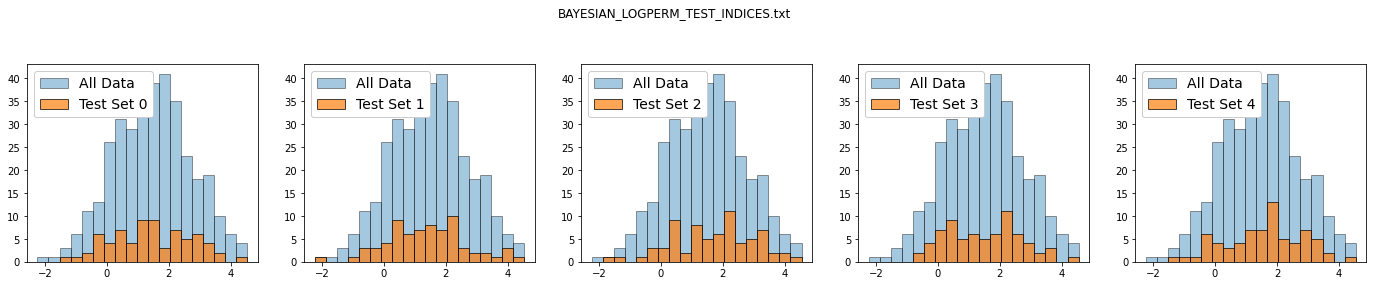

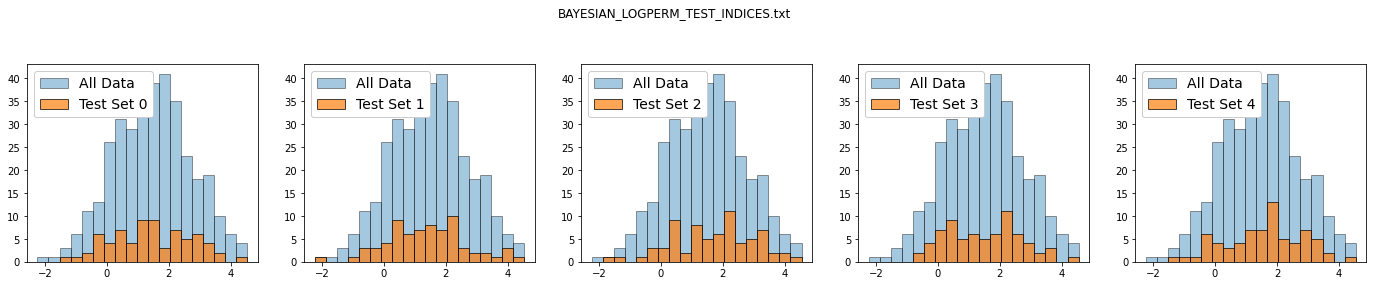

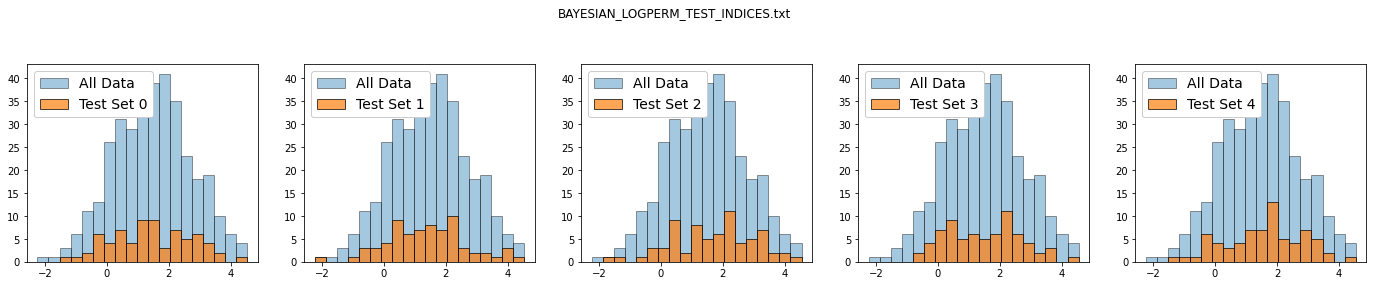

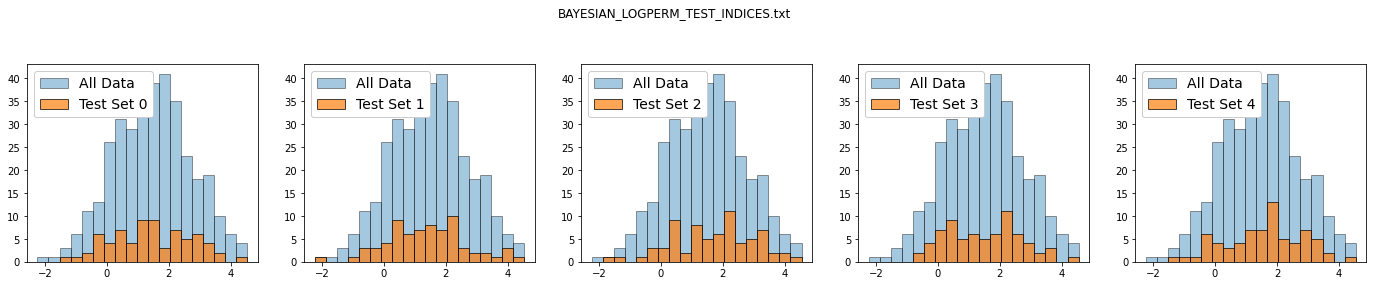

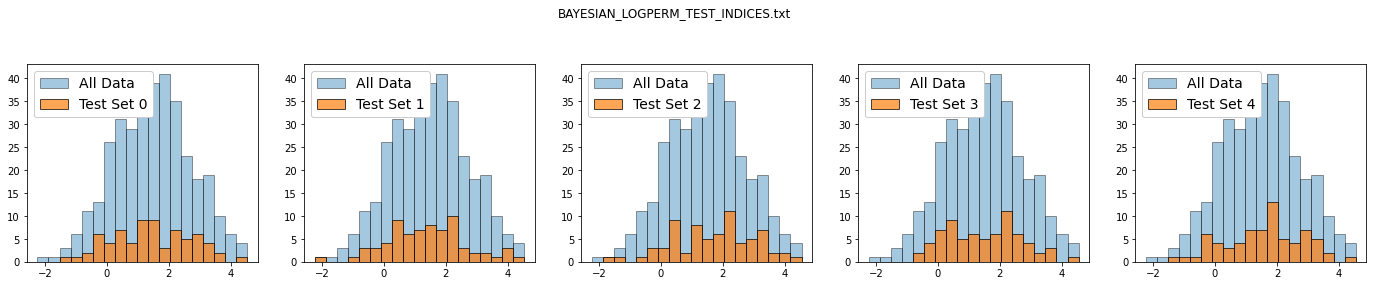

In [27]:
# ALL 5 OF THE SPLIT SETS IN THE IBM DATABASE ARE IDENTICAL - KEEP THAT AS THE FIRST SPLIT AND GENERATE 4 MORE RANDOM ONES
#---------------------------------------------------------------------------------------------------------------------------
# BAYES_LOGPERM_TEST_INDICES = []
# for split in range(5):
#     with open(f'bayes_logperm_splits/{split}/test.txt') as f:
#         BAYES_LOGPERM_TEST_INDICES.append([int(idx) for idx in f.read().split('\n')[:-1]])

# print(BAYES_LOGPERM_TEST_INDICES[3])
# print(len(BAYES_LOGPERM_TEST_INDICES[3]))
#---------------------------------------------------------------------------------------------------------------------------

if __name__ == "__main__" and '__file__' not in globals():
    
    def get_n_splits(y, saveLoc, n=5, test_size=0.2):
        out = [sorted(np.random.choice(list(range(len(y))), size=int(test_size*len(y))+1, replace=False)) for i in range(n)]
        # print(len(out[0]))
        with open(saveLoc, 'w') as f:
            f.write(f'{out}')
    
    def split_hist(y, fileName):
        with open(fileName) as f:
            splits = eval(f.read())
    
        bins = np.linspace(min(y), max(y)*1.01, 20)
        plt.figure(figsize=(24,8))
        plt.suptitle(fileName)
        for i,ti in enumerate(splits):
            plt.subplot(2,5,i+1)
            plt.hist(y, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
            test_idx = np.array(ti)
            plt.hist(y[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
            plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')

    if False:
        get_n_splits(bayes_logperm_y[:,0], f'BAYESIAN_LOGPERM_TEST_INDICES.txt')
    for i in range(5):
        split_hist(bayes_logperm_y[:,0], f'BAYESIAN_LOGPERM_TEST_INDICES.txt')


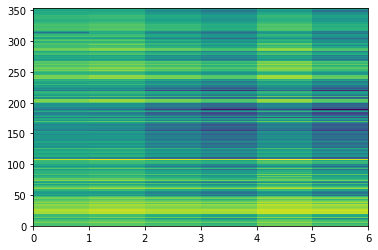

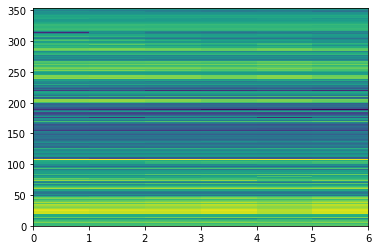

In [28]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.pcolormesh(bayes_logperm_y)
    plt.figure()
    plt.pcolormesh(bayes_logperm_y_zScore)

In [29]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    with open('bayes_logperm_chemprop.csv', 'w') as g:
        g.write('Chemprop_extended_string_representation,y0,y1,y2,y3,y4,y5\n')
        
        with open('permeability_Bayesian.txt') as f:
            
            for entry in f.read().split('\n')[1:-1]:
                
                sm,y0,y1,y2,y3,y4,y5 = entry.split(',')
                string = Chem.MolToSmiles(Chem.MolFromSmiles(sm))
                nas = string.count('*')
                string = string.replace('*','[*]')
                string.replace('-','')
                for i in range(1,nas+1):
                    string = string.replace('[*]',f'[*:{i}]',1)
                frac = round(1/nas, 5)
                string += '|1|'
                for i in range(1,nas+1):
                    for j in range(i,nas+1):
                        string += f'<{i}-{j}:{frac}:{frac}'
                
                g.write(f'{string},{y0},{y1},{y2},{y3},{y4},{y5}\n')
    
    print('done')


In [30]:
np.array([[i]*10 for i in range(3)]).T

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [37]:
def get_n_splits(y, saveLoc, n=5, test_size=0.2):
    out = [sorted(np.random.choice(list(range(len(y))), size=int(test_size*len(y)), replace=False)) for i in range(n)]
    with open(saveLoc, 'w') as f:
        f.write(f'{out}')

def split_hist(y, fileName):
    with open(fileName) as f:
        splits = eval(f.read())

    bins = np.linspace(min(y), max(y)*1.01, 20)
    plt.figure(figsize=(24,8))
    plt.suptitle(fileName)
    for i,ti in enumerate(splits):
        plt.subplot(2,5,i+1)
        plt.hist(y, bins=bins, edgecolor='k', alpha=0.4, label='All Data')
        test_idx = np.array(ti)
        plt.hist(y[test_idx], bins=bins, alpha=0.7, edgecolor='k', label=f'Test Set {i}')
        plt.legend(fontsize=14, framealpha=1, bbox_to_anchor=(0,1), loc='upper left')

In [39]:
# HOPV dataset
hopv = pd.read_csv('rebuttal_data/HOPV.txt', sep=',')
hopv_smiles = np.array(hopv['SMILES'])
hopv_mols = np.array([Chem.MolFromSmiles(sm) for sm in hopv_smiles])

# Morgan Fingerprints
hopv_fp_counts, hopv_fp_inventory = get_fp_counts(hopv_mols, 3, True)

# Labels
hopv_y = np.array(hopv['HOPV'], dtype=float)
hopv_y_zScore = norm_zScore(hopv_y)[0]

print('Database Imported:\tHOPV')
hopv

Database Imported:	HOPV


,SMILES,HOPV
0,COC(=O)C(=Cc1cc(C)c(c2ccc(c3sc(c4cc5c(s4)c(OC)...,-0.246
1,Cc1csc(c2ccc(c3cc(C)cs3)c3nsnc23)c1,-0.259
2,COC(=O)C(=Cc1cc(C)c(c2cc(C)c(c3ccc(c4sc(c5sc(C...,-0.251
3,C[Si]1(C)c2ccsc2c2sc(c3nc4sc(c5cc6c(s5)c5sc(c7...,-0.237
4,COc1c2ccsc2c(OC)c2cc(c3sc(c4scc5c4[C@@H]4C=C[C...,-0.253
...,...,...
311,Cc1c2ccsc2c(C)c2cc(c3ccc(c4cnc(c5cccs5)c5nsnc4...,-0.249
312,CC(=O)c1cc2c(csc2c2cc3c(s2)c(C)c2ccsc2c3C)s1,-0.260
313,Cc1cc(c2ccc(N(c3ccccc3)c3ccccc3)cc2)sc1c1cnc(c...,-0.238
314,Cc1ccc(C2(c3ccc(C)cc3)c3ccsc3c3cc4c(cc23)c2sc(...,-0.243


HOPV mean +/- std: -0.25034177215189873 +/- 0.01439640960509618


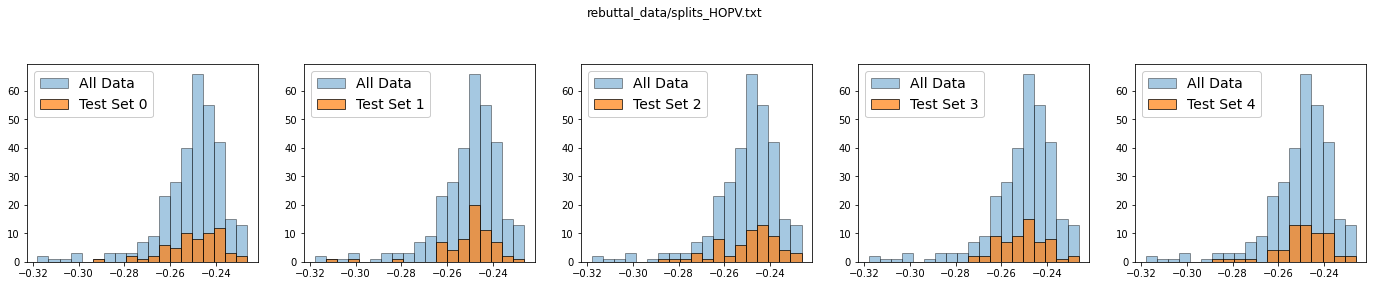

In [38]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():

    if False:
        get_n_splits(hopv_y, f'rebuttal_data/splits_HOPV.txt')
    split_hist(hopv_y, f'rebuttal_data/splits_HOPV.txt')
    print('HOPV mean +/- std:', np.mean(hopv_y), '+/-', np.std(hopv_y))

In [67]:
def read_classification_dataset(dataName):
    
    data = pd.read_csv(f'rebuttal_data/{dataName}.txt', sep=',')
    smiles = np.array(data['SMILES'])
    
    mols, y = [], []
    if len(smiles) != len(list(data[f'{dataName}'])):
        raise Exception
    
    for sm,j in zip(smiles, list(data[f'{dataName}'])):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            mols.append(mol)
            y.append(j)
    mols = np.array(mols)
    y = np.array(y)
    fp_counts, fp_inventory = get_fp_counts(mols, 3, True)
                    
    print(f'Database Imported:\t{dataName} (classification)')
    return data, smiles, mols, y, fp_counts

In [68]:
clintox, clintox_smiles, clintox_mols, clintox_y, clintox_fp_counts = read_classification_dataset('clintox')
clintox

Database Imported:	clintox (classification)


,SMILES,clintox
0,C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1
3,[H][NH+]=C(C1=CC(=O)C(=CC=c2ccc(=C([NH3+])N)cc...,1
4,[H][NH+]=C(N)c1ccc(cc1)OCCCCCOc2ccc(cc2)C(=[NH...,1
...,...,...
1479,O[Si](=O)O,1
1480,O=[Ti]=O,1
1481,O=[Zn],1
1482,OCl(=O)(=O)=O,1


clintox mean +/- std: 0.9364005412719891 +/- 0.2440380453484966


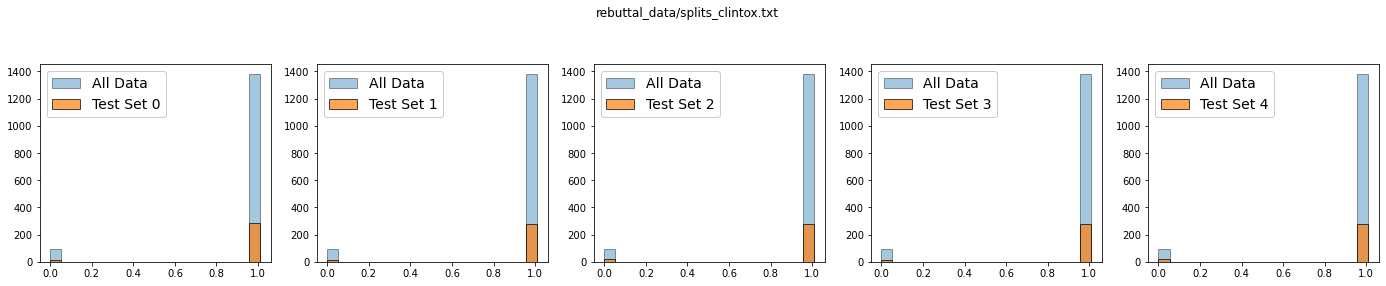

In [69]:
# Create Test Set Splits to be used (same across different models/settings/experiments)

if __name__ == "__main__" and '__file__' not in globals():

    if False:
        get_n_splits(clintox_y, f'rebuttal_data/splits_clintox.txt')
    split_hist(clintox_y, f'rebuttal_data/splits_clintox.txt')
    print('clintox mean +/- std:', np.mean(clintox_y), '+/-', np.std(clintox_y))

Database Imported:	DILI (classification)
DILI mean +/- std: 0.4112734864300626 +/- 0.4920646357844908


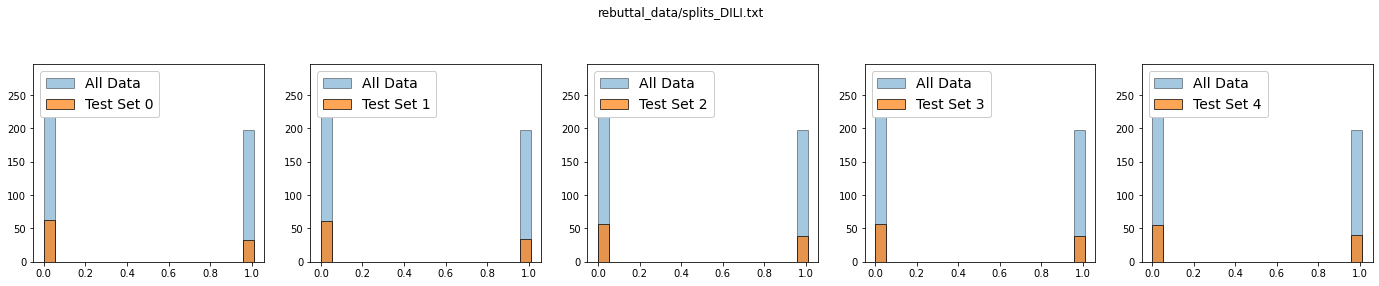

In [71]:
DILI, DILI_smiles, DILI_mols, DILI_y, DILI_fp_counts = read_classification_dataset('DILI')
DILI

if __name__ == "__main__" and '__file__' not in globals():

    if False:
        get_n_splits(DILI_y, f'rebuttal_data/splits_DILI.txt')
    split_hist(DILI_y, f'rebuttal_data/splits_DILI.txt')
    print('DILI mean +/- std:', np.mean(DILI_y), '+/-', np.std(DILI_y))

Database Imported:	PTC (classification)
PTC mean +/- std: 0.40804597701149425 +/- 0.49147172620226015


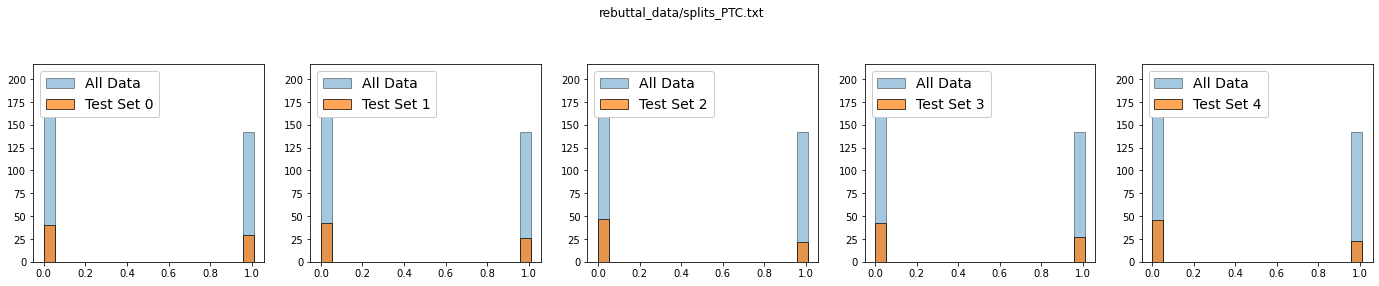

In [74]:
PTC, PTC_smiles, PTC_mols, PTC_y, PTC_fp_counts = read_classification_dataset('PTC')
PTC

if __name__ == "__main__" and '__file__' not in globals():

    if False:
        get_n_splits(PTC_y, f'rebuttal_data/splits_PTC.txt')
    split_hist(PTC_y, f'rebuttal_data/splits_PTC.txt')
    print('PTC mean +/- std:', np.mean(PTC_y), '+/-', np.std(PTC_y))